In [1]:
#Data cleanup here

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.formula.api import ols
import csv
import json
import requests
import seaborn as sns
from bokeh.io import show
from bokeh.models import (CDSView, ColorBar, ColumnDataSource,
                          CustomJS, CustomJSFilter, 
                          GeoJSONDataSource, HoverTool,
                          LinearColorMapper, Slider)
from bokeh.layouts import column, row, widgetbox
from bokeh.palettes import brewer
from bokeh.plotting import figure
import geopandas as gpd
import time
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Pull csv using URL of dataset uploaded to repo

hubs = ['NY', 'CA', 'DC', 'MA', 'MO', 'MI', 'WV', 'AL', 'IN']

types = ['1Bedroom', 
         '2Bedroom', 
         '3Bedroom',
         '4Bedroom', 
         '5BedroomOrMore', 
         'AllHomes',
         'Sfr', 
         'Studio']

df_list = []

for d in types:
    path = f'zillow-house-price-data/City_MedianRentalPrice_{d}.csv'
    dataframe = pd.read_csv(path, error_bad_lines=False)
    dataframe = dataframe[['State', 'RegionName','CountyName','2015-01', 
                            '2015-02','2015-03','2015-04','2015-05', 
                            '2015-06','2015-07','2015-08','2015-09',
                            '2015-10','2015-11','2015-12','2016-01', 
                            '2016-02','2016-03','2016-04','2016-05',
                            '2016-06','2016-07','2016-08','2016-09', 
                            '2016-10','2016-11','2016-12','2017-01', 
                            '2017-02','2017-03','2017-04','2017-05',
                            '2017-06','2017-07','2017-08','2017-09',
                            '2017-10','2017-11','2017-12','2018-01',
                            '2018-02','2018-03','2018-04','2018-05',
                            '2018-06','2018-07','2018-08','2018-09',
                            '2018-10','2018-11','2018-12']]
    dataframe = dataframe.loc[dataframe['State'].isin(hubs)]
    # Convert the data to long form
    dataframe = pd.melt(dataframe, id_vars=['State','RegionName', 'CountyName'])

    #Rename columns
    dataframe.columns = ['State', 'RegionName', 'CountyName', 'Time', 'Value']

    dataframe['Time'] = pd.to_datetime(dataframe['Time']) 
    dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
    dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
    dataframe['Type'] = d
    
    dataframe = dataframe.loc[dataframe['Time'].isin(['2015', '2016', '2017', '2018'])]
    df_list.append(dataframe)


In [3]:
merged_df = df_list[0]

for number in np.arange(1,7):
    merged_df = merged_df.append(df_list[number])


merged_df.head()


,State,RegionName,CountyName,Time,Value,Year,Month,Type
0,NY,New York,Queens County,2015-01-01,2200.0,2015,1,1Bedroom
1,CA,Los Angeles,Los Angeles County,2015-01-01,1755.0,2015,1,1Bedroom
2,CA,San Diego,San Diego County,2015-01-01,1690.0,2015,1,1Bedroom
3,CA,San Jose,Santa Clara County,2015-01-01,2335.0,2015,1,1Bedroom
4,IN,Indianapolis,Marion County,2015-01-01,566.0,2015,1,1Bedroom


In [4]:
df_avg = merged_df.loc[merged_df['Type'] == 'AllHomes'].dropna()
df_avg = df_avg.groupby(['State', 'CountyName', 'Year'])['Value'].mean()
df_avg = df_avg.reset_index()
df_avg

df_avg['CountyName'] = df_avg["CountyName"].str.replace(" County", "") 
  
df_avg['Value'].quantile([0.25, 0.5, 0.75])
df_avg.head()

,State,CountyName,Year,Value
0,AL,Baldwin,2015,1437.5
1,AL,Baldwin,2016,1375.0
2,AL,Baldwin,2017,1350.0
3,AL,Baldwin,2018,1400.0
4,AL,Coffee,2015,850.0


In [5]:
counties_usa = gpd.read_file('cb_2018_us_county_20m/cb_2018_us_county_20m.shp')
counties_usa.columns = ['STATEFP', 'COUNTYFP', 'COUNTYNS', 'AFFGEOID', 'GEOID', 'CountyName', 'LSAD',
       'ALAND', 'AWATER', 'geometry']

counties_usa = counties_usa.loc[counties_usa['STATEFP'].isin(['01', '06', '11', '18', '25', '26', '29', '36', '54'])]
counties_usa.head()


,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,CountyName,LSAD,ALAND,AWATER,geometry
7,01,043,00161547,0500000US01043,01043,Cullman,06,1903073019,52422496,"POLYGON ((-87.11199 33.99238, -87.10991 34.299..."
8,54,023,01697238,0500000US54023,54023,Grant,06,1236390677,7545525,"POLYGON ((-79.48687 39.20596, -79.42441 39.228..."
11,18,049,00450353,0500000US18049,18049,Fulton,06,954146352,7426335,"POLYGON ((-86.46705 41.17144, -86.07755 41.172..."
15,01,059,00161555,0500000US01059,01059,Franklin,06,1641841406,32643981,"POLYGON ((-88.15490 34.46303, -88.13956 34.581..."
16,29,175,00758542,0500000US29175,29175,Randolph,06,1250217892,13254191,"POLYGON ((-92.69723 39.59770, -92.69215 39.610..."


In [11]:
df_county = pd.merge(counties_usa, df_avg, on="CountyName", suffixes=("_shape", ""))

df_county.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,CountyName,LSAD,ALAND,AWATER,geometry,State,Year,Value
0,26,121,01623003,0500000US26121,26121,Muskegon,06,1305064357,2476380060,"POLYGON ((-86.46352 43.47233, -86.03949 43.467...",MI,2017,695.0
1,26,121,01623003,0500000US26121,26121,Muskegon,06,1305064357,2476380060,"POLYGON ((-86.46352 43.47233, -86.03949 43.467...",MI,2018,725.0
2,18,127,00450382,0500000US18127,18127,Porter,06,1082793402,268672610,"POLYGON ((-87.22280 41.62889, -87.12583 41.650...",IN,2018,1300.0
3,26,139,01623012,0500000US26139,26139,Ottawa,06,1459502408,2765830983,"POLYGON ((-86.27393 43.11837, -85.90743 43.118...",MI,2017,1100.0
4,26,139,01623012,0500000US26139,26139,Ottawa,06,1459502408,2765830983,"POLYGON ((-86.27393 43.11837, -85.90743 43.118...",MI,2018,1249.0


In [6]:
contiguous_usa = gpd.read_file('cb_2018_us_state_20m/cb_2018_us_state_20m.shp')
contiguous_usa.columns = ['STATEFP', 'STATENS', 'AFFGEOID', 'GEOID', 'STUSPS', 'State', 'LSAD',
       'ALAND', 'AWATER', 'geometry']
contiguous_usa = contiguous_usa.loc[~contiguous_usa['State'].isin(['Alaska', 'Hawaii', 'Puerto Rico'])]

contiguous_usa.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,State,LSAD,ALAND,AWATER,geometry
0,24,01714934,0400000US24,24,MD,Maryland,00,25151100280,6979966958,"MULTIPOLYGON (((-76.04621 38.02553, -76.00734 ..."
1,19,01779785,0400000US19,19,IA,Iowa,00,144661267977,1084180812,"POLYGON ((-96.62187 42.77925, -96.57794 42.827..."
2,10,01779781,0400000US10,10,DE,Delaware,00,5045925646,1399985648,"POLYGON ((-75.77379 39.72220, -75.75323 39.757..."
3,39,01085497,0400000US39,39,OH,Ohio,00,105828882568,10268850702,"MULTIPOLYGON (((-82.86334 41.69369, -82.82572 ..."
4,42,01779798,0400000US42,42,PA,Pennsylvania,00,115884442321,3394589990,"POLYGON ((-80.51989 40.90666, -80.51964 40.987..."


In [12]:
geosource_2015 = GeoJSONDataSource(geojson = df_county.loc[df_county['Year'] == 2015].to_json())
geosource_2016 = GeoJSONDataSource(geojson = df_county.loc[df_county['Year'] == 2016].to_json())
geosource_2017 = GeoJSONDataSource(geojson = df_county.loc[df_county['Year'] == 2017].to_json())
geosource_2018 = GeoJSONDataSource(geojson = df_county.loc[df_county['Year'] == 2018].to_json())
geosource_state_2015 = GeoJSONDataSource(geojson = contiguous_usa.to_json())
geosource_state_2016 = GeoJSONDataSource(geojson = contiguous_usa.to_json())
geosource_state_2017 = GeoJSONDataSource(geojson = contiguous_usa.to_json())
geosource_state_2018 = GeoJSONDataSource(geojson = contiguous_usa.to_json())

In [16]:
## Plot Median Rent in 2015 by County
# Define color palettes
palette = brewer['BuGn'][9]
palette = palette[::-1] # reverse order of colors so higher values have darker colors
# Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 4500) #make sure you set the low and high, if you forget it won't map
# Define custom tick labels for color bar.
tick_labels = {'0': '0', '500': '500',
 '1000':'1000', '1500':'1500',
 '2000':'2000', '2500':'2500',
 '3000':'3000', '3500':'3500',
 '4000':'4000', '4500':'4500+'}
# Create color bar.
color_bar = ColorBar(color_mapper = color_mapper, 
                     label_standoff = 8,
                     width = 500, height = 20,
                     border_line_color = None,
                     location = (0,0), 
                     orientation = 'horizontal',
                     major_label_overrides = tick_labels)
# Create figure object.
p_2015 = figure(title = 'Median Rental Prices, 2015', 
           plot_height = 600, plot_width = 950, 
           toolbar_location = 'below',
           tools = "pan, wheel_zoom, box_zoom, reset")
p_2015.xgrid.grid_line_color = None
p_2015.ygrid.grid_line_color = None

# Add patch renderer to figure.

states = p_2015.patches('xs','ys', source = geosource_state_2015, #your geojson file
                   fill_color = None,
                   line_color = 'gray', 
                   line_width = 0.25, 
                   fill_alpha = 1)

counties = p_2015.patches('xs','ys', source = geosource_2015, #your geojson file
                   fill_color = {'field' :'Value', #this has to be your column name
                                 'transform' : color_mapper},
                   line_color = 'gray', 
                   line_width = 0.25, 
                   fill_alpha = 1)
# Create hover tool
p_2015.add_tools(HoverTool(renderers = [counties],
                      tooltips = [('County','@CountyName'),
                               ('Median Rent','@Value{int}')])) #if you add {int} then it writes as integer, otherwise scientific notation
                                                                #the @ shows the column name, so here I am saying "in hover box show "Median Rent: [value in 'Value' column]{in integer format}
# Specify layout
p_2015.add_layout(color_bar, 'below')

show(p_2015)



In [20]:
## Plot Median Rent in 2016 by County
# Define color palettes
palette = brewer['BuGn'][9]
palette = palette[::-1] # reverse order of colors so higher values have darker colors
# Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 4500) #make sure you set the low and high, if you forget it won't map
# Define custom tick labels for color bar.
tick_labels = {'0': '0', '500': '500',
 '1000':'1000', '1500':'1500',
 '2000':'2000', '2500':'2500',
 '3000':'3000', '3500':'3500',
 '4000':'4000', '4500':'4500+'}
# Create color bar.
color_bar = ColorBar(color_mapper = color_mapper, 
                     label_standoff = 8,
                     width = 500, height = 20,
                     border_line_color = None,
                     location = (0,0), 
                     orientation = 'horizontal',
                     major_label_overrides = tick_labels)
# Create figure object.
p_2016 = figure(title = 'Median Rental Prices, 2016', 
           plot_height = 600, plot_width = 950, 
           toolbar_location = 'below',
           tools = "pan, wheel_zoom, box_zoom, reset")
p_2016.xgrid.grid_line_color = None
p_2016.ygrid.grid_line_color = None
# Add patch renderer to figure.
states = p_2016.patches('xs','ys', source = geosource_state_2016, #your geojson file
                   fill_color = None,
                   line_color = 'gray', 
                   line_width = 0.25, 
                   fill_alpha = 1)

counties = p_2016.patches('xs','ys', source = geosource_2016, #your geojson file
                   fill_color = {'field' :'Value', #this has to be your column name
                                 'transform' : color_mapper},
                   line_color = 'gray', 
                   line_width = 0.25, 
                   fill_alpha = 1)
# Create hover tool
p_2016.add_tools(HoverTool(renderers = [counties], #your patch rendered dataset
                      tooltips = [('County','@CountyName'),
                               ('Median Rent','@Value{int}')])) #if you add {int} then it writes as integer, otherwise scientific notation
                                                                #the @ shows the column name, so here I am saying "in hover box show "Median Rent: [value in 'Value' column]{in integer format}
# Specify layout
p_2016.add_layout(color_bar, 'below')
show(p_2016)



In [10]:
## Plot Median Rent in 2017 by County
# Define color palettes
palette = brewer['BuGn'][9]
palette = palette[::-1] # reverse order of colors so higher values have darker colors
# Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 4500) #make sure you set the low and high, if you forget it won't map
# Define custom tick labels for color bar.
tick_labels = {'0': '0', '500': '500',
 '1000':'1000', '1500':'1500',
 '2000':'2000', '2500':'2500',
 '3000':'3000', '3500':'3500',
 '4000':'4000', '4500':'4500+'}
# Create color bar.
color_bar = ColorBar(color_mapper = color_mapper, 
                     label_standoff = 8,
                     width = 500, height = 20,
                     border_line_color = None,
                     location = (0,0), 
                     orientation = 'horizontal',
                     major_label_overrides = tick_labels)
# Create figure object.
p_2017 = figure(title = 'Median Rental Prices, 2017', 
           plot_height = 600, plot_width = 950, 
           toolbar_location = 'below',
           tools = "pan, wheel_zoom, box_zoom, reset")
p_2017.xgrid.grid_line_color = None
p_2017.ygrid.grid_line_color = None
# Add patch renderer to figure.
states = p_2017.patches('xs','ys', source = geosource_state_2017, #your geojson file
                   fill_color = None,
                   line_color = 'gray', 
                   line_width = 0.25, 
                   fill_alpha = 1)

counties = p_2017.patches('xs','ys', source = geosource_2017, #your geojson file
                   fill_color = {'field' :'Value', #this has to be your column name
                                 'transform' : color_mapper},
                   line_color = 'gray', 
                   line_width = 0.25, 
                   fill_alpha = 1)
# Create hover tool
p_2017.add_tools(HoverTool(renderers = [counties],
                      tooltips = [('County','@CountyName'),
                               ('Median Rent','@Value{int}')])) #if you add {int} then it writes as integer, otherwise scientific notation
                                                                #the @ shows the column name, so here I am saying "in hover box show "Median Rent: [value in 'Value' column]{in integer format}
# Specify layout
p_2017.add_layout(color_bar, 'below')
show(p_2017)


In [11]:
## Plot Median Rent in 2018 by County
# Define color palettes
palette = brewer['BuGn'][9]
palette = palette[::-1] # reverse order of colors so higher values have darker colors
# Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 4500) #make sure you set the low and high, if you forget it won't map
# Define custom tick labels for color bar.
tick_labels = {'0': '0', '500': '500',
 '1000':'1000', '1500':'1500',
 '2000':'2000', '2500':'2500',
 '3000':'3000', '3500':'3500',
 '4000':'4000', '4500':'4500+'}
# Create color bar.
color_bar = ColorBar(color_mapper = color_mapper, 
                     label_standoff = 8,
                     width = 500, height = 20,
                     border_line_color = None,
                     location = (0,0), 
                     orientation = 'horizontal',
                     major_label_overrides = tick_labels)
# Create figure object.
p_2018 = figure(title = 'Median Rental Prices, 2018', 
           plot_height = 600, plot_width = 950, 
           toolbar_location = 'below',
           tools = "pan, wheel_zoom, box_zoom, reset")
p_2018.xgrid.grid_line_color = None
p_2018.ygrid.grid_line_color = None

# Add patch renderer to figure.
states = p_2018.patches('xs','ys', source = geosource_state_2018, #your geojson file
                   fill_color = None,
                   line_color = 'gray', 
                   line_width = 0.25, 
                   fill_alpha = 1)

counties = p_2018.patches('xs','ys', source = geosource_2018, #your geojson file
                   fill_color = {'field' :'Value', #this has to be your column name
                                 'transform' : color_mapper},
                   line_color = 'gray', 
                   line_width = 0.25, 
                   fill_alpha = 1)
# Create hover tool
p_2018.add_tools(HoverTool(renderers = [states],
                      tooltips = [('County','@CountyName'),
                               ('Median Rent','@Value{int}')])) #if you add {int} then it writes as integer, otherwise scientific notation
                                                                #the @ shows the column name, so here I am saying "in hover box show "Median Rent: [value in 'Value' column]{in integer format}
# Specify layout
p_2018.add_layout(color_bar, 'below')
show(p_2018)


In [7]:
df_avg_change = pd.merge(df_avg.loc[df_avg['Year'] == 2018], df_avg.loc[df_avg['Year'] == 2015], 
                            on=['State', 'CountyName'], suffixes=('_2018', '_2015'))

df_avg_change['Change'] = df_avg_change['Value_2018'] - df_avg_change['Value_2015']

df_avg_change['Change'].quantile([0.25, 0.5, 0.75])

0.25     24.062500
0.50    102.000000
0.75    269.307292
Name: Change, dtype: float64

In [8]:
df_county_change = pd.merge(counties_usa, df_avg_change, on="CountyName", suffixes=("_shape", ""))
df_county_change.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,CountyName,LSAD,ALAND,AWATER,geometry,State,Year_2018,Value_2018,Year_2015,Value_2015,Change
0,01,073,00161562,0500000US01073,01073,Jefferson,06,2878465205,32885044,"POLYGON ((-87.26692 33.51293, -87.27159 33.529...",AL,2018,1026.25,2015,1072.5,-46.25
1,54,037,01550025,0500000US54037,54037,Jefferson,06,542073029,6150169,"POLYGON ((-78.03545 39.27822, -77.98818 39.320...",AL,2018,1026.25,2015,1072.5,-46.25
2,18,077,00450363,0500000US18077,18077,Jefferson,06,934033952,5843998,"POLYGON ((-85.68384 38.81541, -85.61059 38.824...",AL,2018,1026.25,2015,1072.5,-46.25
3,29,099,00758504,0500000US29099,29099,Jefferson,06,1700345322,20143587,"POLYGON ((-90.74940 38.35819, -90.73760 38.415...",AL,2018,1026.25,2015,1072.5,-46.25
4,36,045,00974121,0500000US36045,36045,Jefferson,06,3285906470,1524628784,"POLYGON ((-76.41214 43.92568, -76.27931 43.972...",AL,2018,1026.25,2015,1072.5,-46.25


In [9]:
geosource_1518 = GeoJSONDataSource(geojson = df_county_change.to_json())
geosource_state_1518 = GeoJSONDataSource(geojson = contiguous_usa.to_json())

In [10]:
## Plot Median Rent Change from 2015 to 2018 by County
# Define color palettes
palette = brewer['RdBu'][7]
palette = palette[::-1] # reverse order of colors so higher values have darker colors
# Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = -2500, high = 1000) #make sure you set the low and high, if you forget it won't map
# Define custom tick labels for color bar.
tick_labels = {'-2500': '-2500', '-2000': '-2000',
 '-1500':'-1500', '-1000':'-1000',
 '-500':'-500', '0':'0',
 '500':'500', '1000':'1000+'}
# Create color bar.
color_bar = ColorBar(color_mapper = color_mapper, 
                     label_standoff = 8,
                     width = 500, height = 20,
                     border_line_color = None,
                     location = (0,0), 
                     orientation = 'horizontal',
                     major_label_overrides = tick_labels)
# Create figure object.
p_1518 = figure(title = 'Median Rental Price Change from 2015 to 2018', 
           plot_height = 600, plot_width = 950, 
           toolbar_location = 'below',
           tools = "pan, wheel_zoom, box_zoom, reset")
p_1518.xgrid.grid_line_color = None
p_1518.ygrid.grid_line_color = None

# Add patch renderer to figure.
states = p_1518.patches('xs','ys', source = geosource_state_1518, #your geojson file
                   fill_color = None,
                   line_color = 'gray', 
                   line_width = 0.25, 
                   fill_alpha = 1)

counties = p_1518.patches('xs','ys', source = geosource_1518, #your geojson file
                   fill_color = {'field' :'Change', #this has to be your column name
                                 'transform' : color_mapper},
                   line_color = 'gray', 
                   line_width = 0.25, 
                   fill_alpha = 1)
# Create hover tool
p_1518.add_tools(HoverTool(renderers = [counties],
                      tooltips = [('County','@CountyName'),
                               ('Median Rent','@Change{int}')])) #if you add {int} then it writes as integer, otherwise scientific notation
                                                                #the @ shows the column name, so here I am saying "in hover box show "Median Rent: [value in 'Value' column]{in integer format}
# Specify layout
p_1518.add_layout(color_bar, 'below')
show(p_1518)


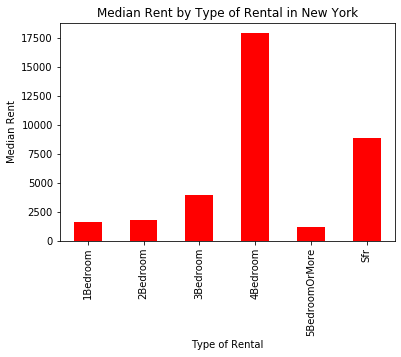

<Figure size 432x288 with 0 Axes>

In [32]:
types_ny = merged_df.loc[~(merged_df['Type'] == 'AllHomes') & (merged_df['State'] == 'NY')].groupby(['Type'])['Value'].mean()
types_ny.plot(kind='bar', color='red')

# Set textual properties
plt.title("Median Rent by Type of Rental in New York")
plt.ylabel("Median Rent")
plt.xlabel("Type of Rental")
# Show plot
plt.show()
plt.tight_layout()




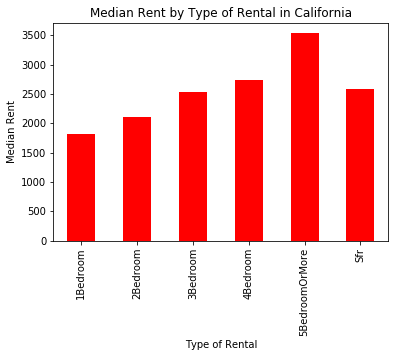

<Figure size 432x288 with 0 Axes>

In [33]:
types_ca = merged_df.loc[~(merged_df['Type'] == 'AllHomes') & (merged_df['State'] == 'CA')].groupby(['Type'])['Value'].mean()
types_ca.plot(kind='bar', color='red')

# Set textual properties
plt.title("Median Rent by Type of Rental in California")
plt.ylabel("Median Rent")
plt.xlabel("Type of Rental")
# Show plot
plt.show()
plt.tight_layout()


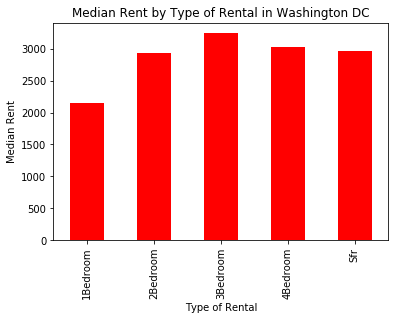

<Figure size 432x288 with 0 Axes>

In [34]:
types_dc = merged_df.loc[~(merged_df['Type'] == 'AllHomes') & (merged_df['State'] == 'DC')].groupby(['Type'])['Value'].mean()
types_dc.plot(kind='bar', color='red')

# Set textual properties
plt.title("Median Rent by Type of Rental in Washington DC")
plt.ylabel("Median Rent")
plt.xlabel("Type of Rental")
# Show plot
plt.show()
plt.tight_layout()


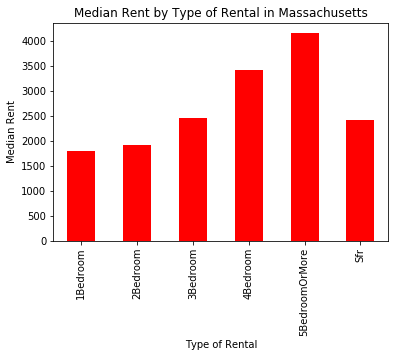

<Figure size 432x288 with 0 Axes>

In [35]:
types_ma = merged_df.loc[~(merged_df['Type'] == 'AllHomes') & (merged_df['State'] == 'MA')].groupby(['Type'])['Value'].mean()
types_ma.plot(kind='bar', color='red')

# Set textual properties
plt.title("Median Rent by Type of Rental in Massachusetts")
plt.ylabel("Median Rent")
plt.xlabel("Type of Rental")
# Show plot
plt.show()
plt.tight_layout()


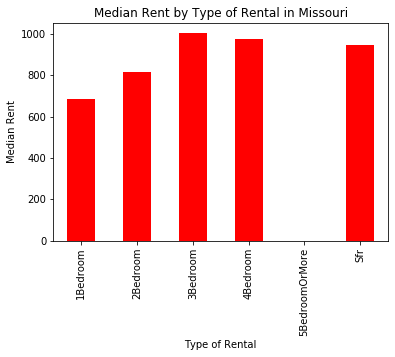

<Figure size 432x288 with 0 Axes>

In [36]:
types_mo = merged_df.loc[~(merged_df['Type'] == 'AllHomes') & (merged_df['State'] == 'MO')].groupby(['Type'])['Value'].mean()
types_mo.plot(kind='bar', color='red')

# Set textual properties
plt.title("Median Rent by Type of Rental in Missouri")
plt.ylabel("Median Rent")
plt.xlabel("Type of Rental")
# Show plot
plt.show()
plt.tight_layout()

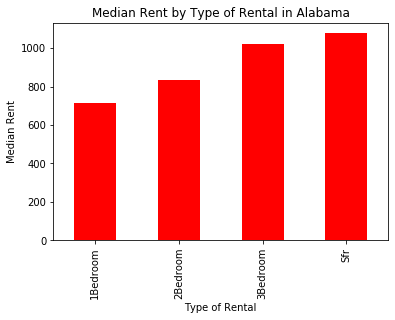

<Figure size 432x288 with 0 Axes>

In [37]:
types_al = merged_df.loc[~(merged_df['Type'] == 'AllHomes') & (merged_df['State'] == 'AL')].groupby(['Type'])['Value'].mean()
types_al.plot(kind='bar', color='red')

# Set textual properties
plt.title("Median Rent by Type of Rental in Alabama")
plt.ylabel("Median Rent")
plt.xlabel("Type of Rental")
# Show plot
plt.show()
plt.tight_layout()


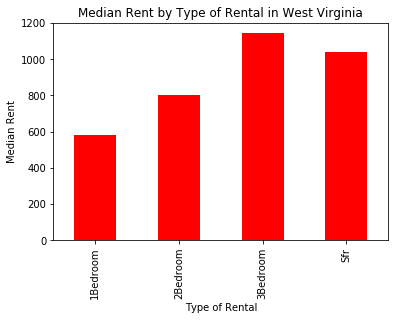

<Figure size 432x288 with 0 Axes>

In [39]:
types_wv = merged_df.loc[~(merged_df['Type'] == 'AllHomes') &  (merged_df['State'] == 'WV')].groupby(['Type'])['Value'].mean()
types_wv.plot(kind='bar', color='red')

# Set textual properties
plt.title("Median Rent by Type of Rental in West Virginia")
plt.ylabel("Median Rent")
plt.xlabel("Type of Rental")
# Show plot
plt.show()
plt.tight_layout()

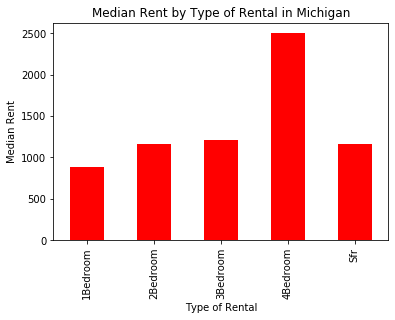

<Figure size 432x288 with 0 Axes>

In [40]:
types_mi = merged_df.loc[~(merged_df['Type'] == 'AllHomes') & (merged_df['State'] == 'MI')].groupby(['Type'])['Value'].mean()
types_mi.plot(kind='bar', color='red')

# Set textual properties
plt.title("Median Rent by Type of Rental in Michigan")
plt.ylabel("Median Rent")
plt.xlabel("Type of Rental")
# Show plot
plt.show()
plt.tight_layout()


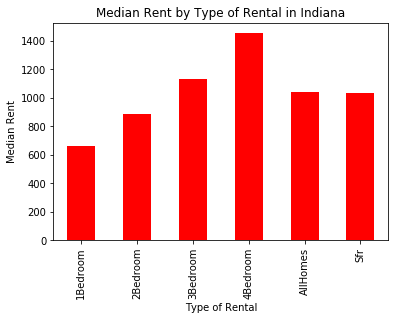

<Figure size 432x288 with 0 Axes>

In [29]:
types_in = merged_df.loc[~(merged_df['Type'] == 'AllHomes') & (merged_df['State'] == 'IN')].groupby(['Type'])['Value'].mean()
types_in.plot(kind='bar', color='red')

# Set textual properties
plt.title("Median Rent by Type of Rental in Indiana")
plt.ylabel("Median Rent")
plt.xlabel("Type of Rental")
# Show plot
plt.show()
plt.tight_layout()


In [69]:
all_homes = pd.read_csv('all_homes_long.csv')
del all_homes['Unnamed: 0']
del all_homes['SizeRank']

all_homes.head()


,RegionName,Time,Value,Year,Month
0,California,2015-01-01,2100.0,2015,1
1,Texas,2015-01-01,1350.0,2015,1
2,New York,2015-01-01,3000.0,2015,1
3,Florida,2015-01-01,1550.0,2015,1
4,Illinois,2015-01-01,1550.0,2015,1


In [67]:
X = all_homes[['RegionName']]
Y = all_homes['Value']
X = pd.get_dummies(data=X, drop_first=True)

# f_regression(X, Y)
# regr = linear_model.LinearRegression() # Do not use fit_intercept = False if you have removed 1 column after dummy encoding
# regr.fit(X, Y)
# predicted = regr.predict(X_test)

X2 = sm.add_constant(X)
est = sm.OLS(Y, X2)
est2 = est.fit()
print(est2.summary())


                            OLS Regression Results                            
Dep. Variable:                  Value   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     1535.
Date:                Sun, 29 Mar 2020   Prob (F-statistic):               0.00
Time:                        17:21:35   Log-Likelihood:                -13498.
No. Observations:                2304   AIC:                         2.709e+04
Df Residuals:                    2256   BIC:                         2.737e+04
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [68]:
# p values
p_values = est2.summary2().tables[1]['P>|t|']
len(p_values)

48

In [71]:
all_homes_change = pd.merge(all_homes.loc[all_homes['Year'] == 2015], 
                            all_homes.loc[all_homes['Year'] == 2018], 
                            on = ['RegionName', 'Month'], 
                            suffixes = ('_2015', '_2018'))

all_homes_change.head()


,RegionName,Time_2015,Value_2015,Year_2015,Month,Time_2018,Value_2018,Year_2018
0,California,2015-01-01,2100.0,2015,1,2018-01-01,2600.0,2018
1,Texas,2015-01-01,1350.0,2015,1,2018-01-01,1495.0,2018
2,New York,2015-01-01,3000.0,2015,1,2018-01-01,3200.0,2018
3,Florida,2015-01-01,1550.0,2015,1,2018-01-01,1799.0,2018
4,Illinois,2015-01-01,1550.0,2015,1,2018-01-01,1550.0,2018


In [72]:
all_homes_change['Change'] = all_homes_change['Value_2018'] - all_homes_change['Value_2015']

all_homes_change

,RegionName,Time_2015,Value_2015,Year_2015,Month,Time_2018,Value_2018,Year_2018,Change
0,California,2015-01-01,2100.0,2015,1,2018-01-01,2600.0,2018,500.0
1,Texas,2015-01-01,1350.0,2015,1,2018-01-01,1495.0,2018,145.0
2,New York,2015-01-01,3000.0,2015,1,2018-01-01,3200.0,2018,200.0
3,Florida,2015-01-01,1550.0,2015,1,2018-01-01,1799.0,2018,249.0
4,Illinois,2015-01-01,1550.0,2015,1,2018-01-01,1550.0,2018,0.0
...,...,...,...,...,...,...,...,...,...
571,Delaware,2015-12-01,1300.0,2015,12,2018-12-01,1400.0,2018,100.0
572,South Dakota,2015-12-01,1100.0,2015,12,2018-12-01,1112.5,2018,12.5
573,Alaska,2015-12-01,1675.0,2015,12,2018-12-01,1600.0,2018,-75.0
574,District of Columbia,2015-12-01,2500.0,2015,12,2018-12-01,2600.0,2018,100.0


In [73]:
X_change = all_homes_change[['RegionName']]
Y_change = all_homes_change['Change']
X_change = pd.get_dummies(data=X_change, drop_first=True)

# f_regression(X, Y)
# regr = linear_model.LinearRegression() # Do not use fit_intercept = False if you have removed 1 column after dummy encoding
# regr.fit(X, Y)
# predicted = regr.predict(X_test)

X2_change = sm.add_constant(X_change)
est_change = sm.OLS(Y_change, X2_change)
est2_change = est_change.fit()
print(est2_change.summary())


                            OLS Regression Results                            
Dep. Variable:                 Change   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     99.41
Date:                Sun, 29 Mar 2020   Prob (F-statistic):          7.69e-231
Time:                        17:25:54   Log-Likelihood:                -2976.5
No. Observations:                 576   AIC:                             6049.
Df Residuals:                     528   BIC:                             6258.
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [74]:
p_values_change = est2_change.summary2().tables[1]['P>|t|']
len(p_values_change)


48